# Flight and Traffic data 

In [1]:
import pickle
import athena
import pandas as pd
import seaborn as sns

In [2]:
db = athena.database.AthenaDatabase(cache=True)

flights = db.flight_passengers()
control = db.control_plaza()

flights.index = flights.index.map(lambda x: x.tz_convert('US/Central').replace(tzinfo=None))
control.index = control.index.map(lambda x: x.tz_convert('US/Central').replace(tzinfo=None))

pickle.dump( flights, open( "flights.pkl", "wb" ) )
pickle.dump( control, open( "control.pkl", "wb" ) )

In [3]:
flights = pickle.load( open( "flights.pkl", "rb" ) )
control = pickle.load( open( "control.pkl", "rb" ) )

We need to combine these into a single DataFrame.

In [4]:
tmp = flights.resample("30min").sum()
df = pd.concat([ control, tmp ], axis=1)
df.rename(columns={'count': 'y'}, inplace=True)
df.dropna(inplace=True)
df['terminal_passengers'] = df['num_seats']*0.8
df['passengers'] = df['terminal_passengers']*0.38

# add some features
df['time'] = df.index.map(lambda x: x.time())
df['hour'] = df.index.map(lambda x: x.hour)
df['day'] = df.index.map(lambda x: x.day)
df['month'] = df.index.map(lambda x: x.month)
df['year'] = df.index.map(lambda x: x.year)

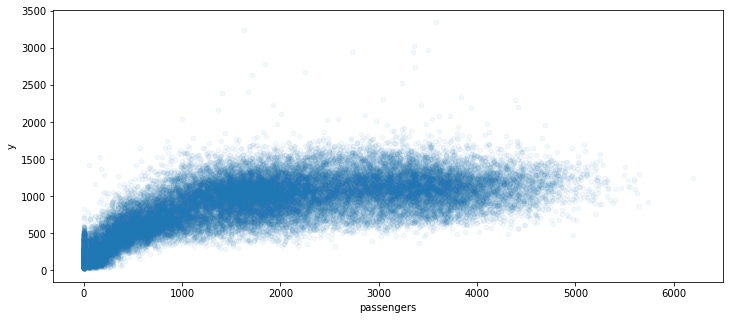

In [5]:
df.plot.scatter(y='y', x='passengers', alpha=0.05, figsize=(12,5))

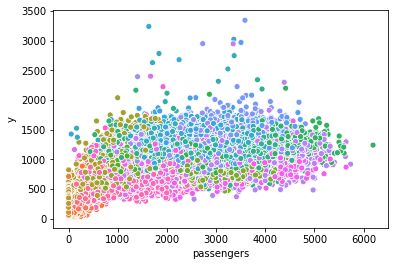

In [6]:
sns.scatterplot(y='y', x='passengers', data=df, hue='time', legend=False)

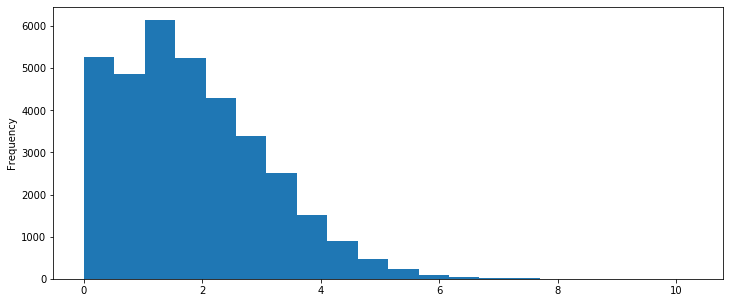

In [7]:
df['passengers'].divide(df['y']).plot(kind='hist', bins=20, figsize=(12,5))

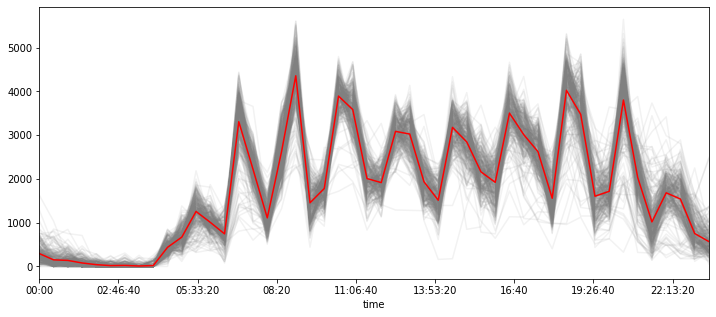

In [8]:
def plot_time(value, col):
    tmp = df.query("year==2018").pivot_table(index=col,  
                    values=value, 
                    columns=['day', 'month'])
    tmp.plot(legend=False, alpha=0.1, color='grey', figsize=(12,5))
    tmp.mean(axis=1).plot(color='red')
    
plot_time("passengers", "time")

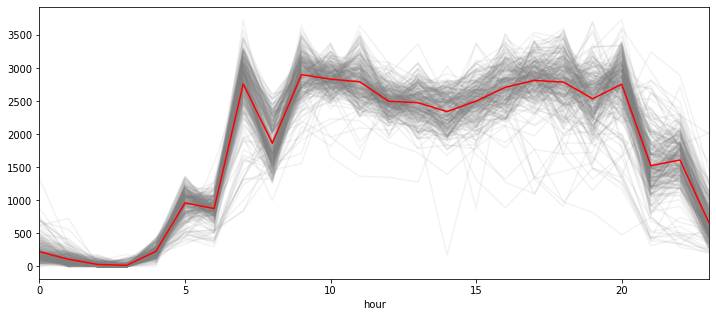

In [9]:
plot_time("passengers", "hour")

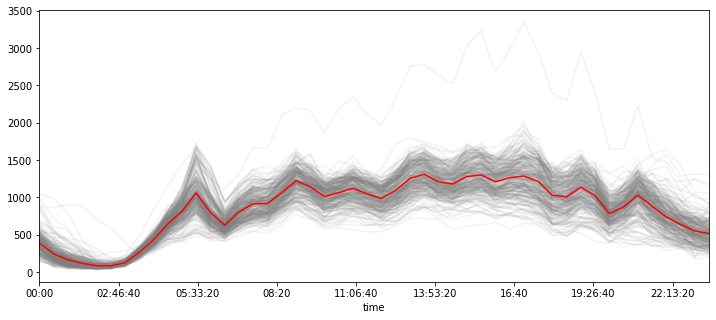

In [10]:
plot_time("y", "time")

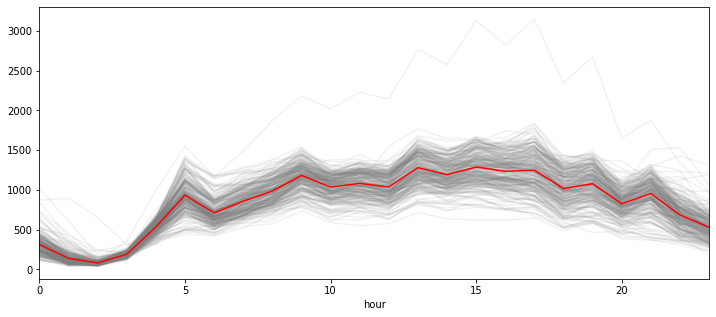

In [11]:
plot_time("y", "hour")

## Adjust the passenger data to account for arrival and departure

In [12]:
# we shift arrivals by 40 minutes after and departures by 100 minutes before
tmp = athena.database.shift_flights(flights, 40, 10, 100, 10)
tmp['num_seats'] = tmp['shifted']
df = pd.concat([ control, tmp ], axis=1)
df.rename(columns={'count': 'y'}, inplace=True)
df.dropna(inplace=True)
df['terminal_passengers'] = df['num_seats']*0.8
df['passengers'] = df['terminal_passengers']*0.38

# add some features
df['time'] = df.index.map(lambda x: x.time())
df['hour'] = df.index.map(lambda x: x.hour)
df['day'] = df.index.map(lambda x: x.day)
df['month'] = df.index.map(lambda x: x.month)
df['year'] = df.index.map(lambda x: x.year)

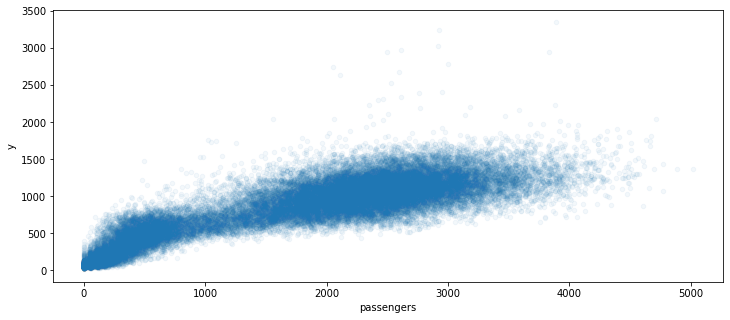

In [13]:
df.plot.scatter(y='y', x='passengers', alpha=0.05, figsize=(12,5))

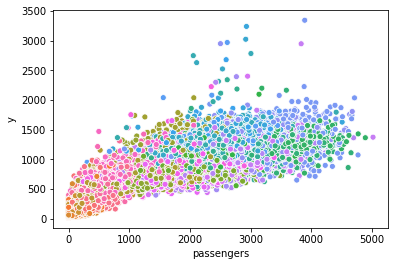

In [14]:
sns.scatterplot(y='y', x='passengers', data=df, hue='time', legend=False)

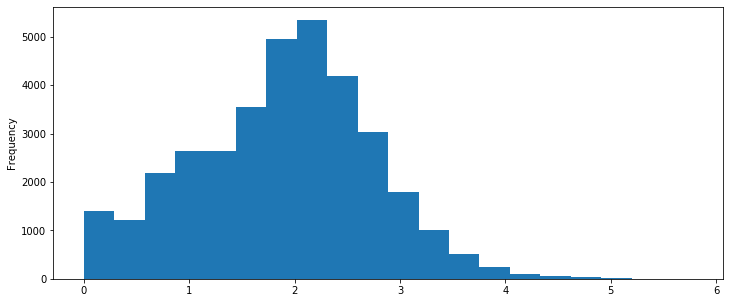

In [15]:
df['passengers'].divide(df['y']).plot(kind='hist', bins=20, figsize=(12,5))

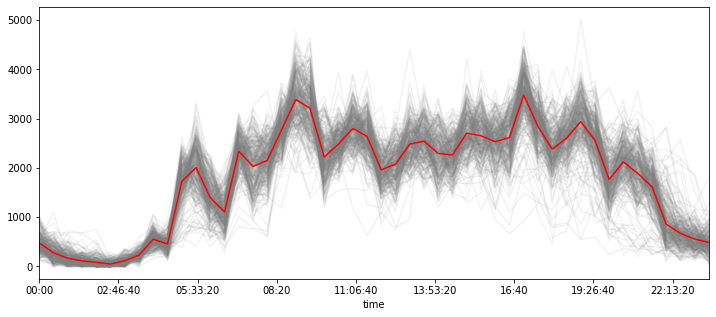

In [16]:
plot_time("passengers", "time")

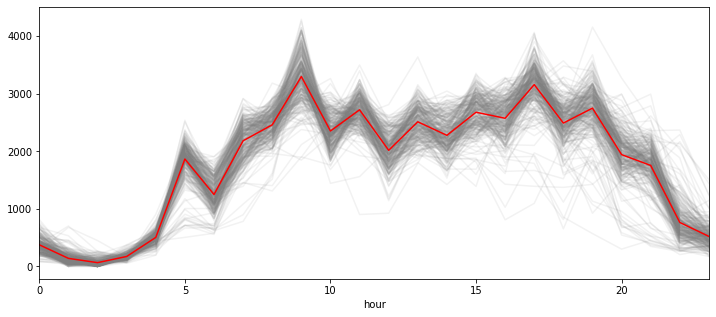

In [17]:
plot_time("passengers", "hour")

##  Add international

In [18]:
codes = db.airport_country_codes()

df = pd.merge(flights.reset_index(), codes, left_on='flight_dest_org', right_on='IATA Code')
df['DI'] = df['Country'].map(lambda x: "domestic" if x=='United States' else "international")
df.set_index('period', inplace=True)

In [19]:
# we shift arrivals by 40 minutes after and departures by 100 minutes before
tmp = athena.database.shift_flights_international(df, 35, 10, 100, 10, 40, 10, 130, 10)
tmp['num_seats'] = tmp['shifted']
df = pd.concat([ control, tmp ], axis=1)
df.rename(columns={'count': 'y'}, inplace=True)
df.dropna(inplace=True)
df['terminal_passengers'] = df['num_seats']*0.8
df['passengers'] = df['terminal_passengers']*0.38

# add some features
df['time'] = df.index.map(lambda x: x.time())
df['hour'] = df.index.map(lambda x: x.hour)
df['day'] = df.index.map(lambda x: x.day)
df['month'] = df.index.map(lambda x: x.month)
df['year'] = df.index.map(lambda x: x.year)

In [20]:
df

,y,arival_domestic,departure_domestic,arrival_international,departure_international,shifted,flights,seats,num_seats,terminal_passengers,passengers,time,hour,day,month,year
2016-10-01 00:00:00,372.0,1.000000,0.000000,0.000000,0.000000,1268.0,5.0,1047.0,1268.0,1014.4,385.472,00:00:00,0,1,10,2016
2016-10-01 00:30:00,196.0,1.000000,0.000000,0.000000,0.000000,865.0,2.0,294.0,865.0,692.0,262.960,00:30:00,0,1,10,2016
2016-10-01 01:00:00,103.0,1.000000,0.000000,0.000000,0.000000,199.0,0.0,0.0,199.0,159.2,60.496,01:00:00,1,1,10,2016
2016-10-01 03:00:00,105.0,0.000000,1.000000,0.000000,0.000000,162.0,1.0,0.0,162.0,129.6,49.248,03:00:00,3,1,10,2016
2016-10-01 03:30:00,206.0,0.521320,0.478680,0.000000,0.000000,727.0,0.0,0.0,727.0,581.6,221.008,03:30:00,3,1,10,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-29 08:30:00,871.0,0.067976,0.510473,0.067372,0.354179,9930.0,59.0,8982.0,9930.0,7944.0,3018.720,08:30:00,8,29,9,2018
2018-09-29 09:00:00,1097.0,0.327265,0.576962,0.083131,0.012642,9888.0,83.0,13813.0,9888.0,7910.4,3005.952,09:00:00,9,29,9,2018
2018-09-29 09:30:00,1032.0,0.656804,0.328402,0.014794,0.000000,11626.0,25.0,3537.0,11626.0,9300.8,3534.304,09:30:00,9,29,9,2018
2018-09-29 10:00:00,854.0,0.541966,0.316176,0.015782,0.126076,5576.0,36.0,5816.0,5576.0,4460.8,1695.104,10:00:00,10,29,9,2018


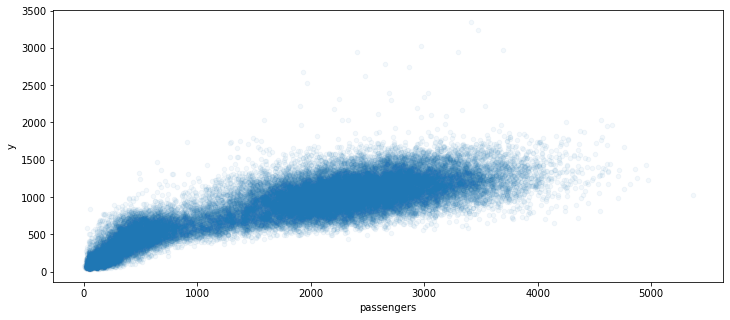

In [21]:
df.plot.scatter(y='y', x='passengers', alpha=0.05, figsize=(12,5))

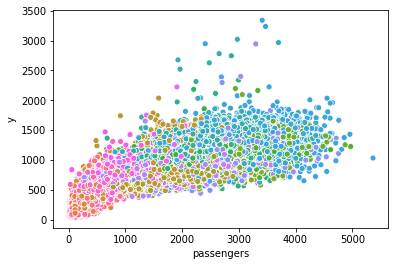

In [22]:
sns.scatterplot(y='y', x='passengers', data=df, hue='time', legend=False)

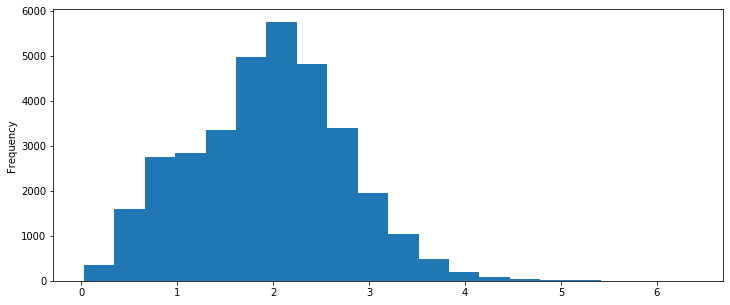

In [23]:
df['passengers'].divide(df['y']).plot(kind='hist', bins=20, figsize=(12,5))

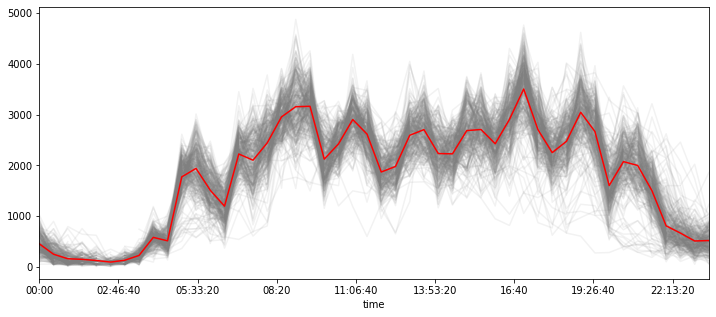

In [24]:
plot_time("passengers", "time")

In [25]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [36]:
class Transformer:

    def __init__(self, numeric_columns, categorical_columns=[]):
        self._num_cols = numeric_columns
        self._cat_cols = categorical_columns

        numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
        categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

        self._preprocessor = ColumnTransformer( transformers=[
                                ('shifted', numeric_transformer, self._num_cols),
                                ('time_cols', categorical_transformer, self._cat_cols),
                                ])

    def fit(self, X):
        self._preprocessor.fit(X[self._num_cols + self._cat_cols])
        return self

    def transform(self, X):
        return self._preprocessor.transform(X[self._num_cols + self._cat_cols])


def flights():
    return pickle.load( open( "flights.pkl", "rb" ) )

def control_plaza():
    return pickle.load( open( "control.pkl", "rb" ) )

def evaluate(df, num_cols, cat_cols=[]):
    t = Transformer(num_cols, cat_cols)
    t.fit(df)
    X = t.transform(df)
    y = df['y'].values
    m = LinearRegression()
    res = []
    for train, test in ShuffleSplit(n_splits=5).split(X):
        m.fit(X[train], y[train])
        y_train = m.predict(X[train])
        y_test = m.predict(X[test])

        res.append({'train': athena.learning.rmse(y_train, y[train] ),
                    'test': athena.learning.rmse(y_test, y[test] ),})

    return pd.DataFrame(res).mean().to_dict()

evaluate(df, ['passengers'])

{'train': 209.8317808975027, 'test': 209.44901663353357}

In [37]:
evaluate(df, ['passengers', 'arival_domestic', 'departure_domestic', 
              'arrival_international', 'departure_international'])

{'train': 208.05211102416328, 'test': 206.05296562684936}

In [38]:
evaluate(df, ['passengers' ], ['hour', 'month', 'time', 'year'])

{'train': 151.69480713919032, 'test': 151.90084274851952}

In [39]:
df['p1'] = df['passengers'].shift(1)
df['p2'] = df['passengers'].shift(2)
df['p3'] = df['passengers'].shift(3)
df['y1'] = df['y'].shift(1)
df['y2'] = df['y'].shift(2)
df['y3'] = df['y'].shift(3)

df.dropna(inplace=True)

In [40]:
evaluate(df, ['passengers', 'p1', 'p2', 'p3', 'y1', 'y2', 'y3'],
              ['hour', 'month', 'time', 'year'])

{'train': 78.35350895068692, 'test': 78.48569431762812}

In [41]:
evaluate(df, ['passengers', 'arival_domestic', 'departure_domestic', 
              'arrival_international', 'departure_international', 'p1', 'p2', 'p3', 'y1', 'y2', 'y3'],
              ['hour', 'month', 'time', 'year'])

{'train': 78.09805105553968, 'test': 78.22995805575745}